In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import * 

from numpy import *

# Bacterial Antibiotic Resistance


---
## Question: 
### How does a bacterial infection epidemic that develops antibiotic resistance compare to an epidemic of a non-mutating infection?
---
Bacteria are the most diverse and prevalent organism on the planet. While the majority of bacteria are harmless to humans, some potent strains have wreaked havoc on society, especially before the advent of modern medicine and invention of antibiotics. In modern times, the availability of antibiotics has drastically  increased survival and recovery rates of bacterial infections, but this is not to say that the bacteria are helpless in the face of modern medicine. Instead, the frequent use of antibiotics has made many strains of bacteria develop resistance to common antibiotic medications. This model applies this rapid mutation under the stress of antibiotics to both the recovery rate due to the need to try several courses of antibiotics and the ability of people, once recovered, to become susceptible  once again to the mutated bacteria. This is achieved through an SIR stock and flow model that pulls information about bacterial resistance from a second stock and flow and includes an addtional flow from R to S. Overall, this model seeks to find and explain the differences  between the two types of epidemics.

-----
## Method:
This model uses three functions to do work. The first function frames the stock and flow diagram within the code. It establishes the stocks stores them in a state object, then incorporates the flows and extraneous factors and stores them within a system object along with the state object. The second function is the update function which applies the calculated change in each of the stocks. The simulation is completed by the third function which stores the results of the update function from each time step.

#### make_sys Function:
This function is similar to the one in the original SIR model with a few modifications. The state object created (init) still contains the percent of the population in each stock and additionally  stores the percent of bacterial  infections that are of the susceptible strain and of the resistant strain. The recovery time (in days) is separated from the original gamma variable and included because it changes as bacterial antibiotic resistance increases and it is easier to compute, record, and analyze these changes with a more 'real world' variable as opposed to gamma. This function also includes the information for the transition from susceptible strains of the infection to resistant ones.

Currently the varibles used are:
S_pop = 89,
I_pop = 1,
R_pop = 0,
recovery = 6,
max_growth =0.2,
start = 0,
stop = 112,
step = 1/5,
contact_rate = 1/3,

In [2]:
def make_sys(S_pop, I_pop, R_pop, recovery, max_growth, start, end, step, contact_rate):
    """
    Creates a system object with parameters and a state object imbeded. 
    
    S_pop = The intial number of people who may become infected.
    I_pop = The intial number of people who are infected.
    R_pop = The inial number of people who have recoverd from the infection and are now immune.
    
    recovery = The time reqired to complete a treatment of antibiotics. 
    
    max_growth = The maximum rate of turnover from infections with suceptible bacteria to those with resistant bacteia.
                 A required varible in a logistic funcion.
    
    start = Begining of the simulation/epidemic in days.
    end = End of the simulation/epidemic in days.
    step = The number of divisions within a day to increase accuracy.
    
    contact_rate = the proprtion of interations between infectious and suceptible people that result in infection spread.
    """
    #Establishes the intitial percent of the population in each stock.
    tot_pop = S_pop + I_pop + R_pop
    S = S_pop / tot_pop 
    I = I_pop / tot_pop 
    R = R_pop / tot_pop 
    
    #Sets the number of susceptible bacteria infections to 100% and resitant infections to a number close to 0%
    susceptible = 1
    resistant = 0.001
    
    #Creates an object to keep track of the days it takes to recover from the infection.
    reco_time = recovery 
    
    #Creates state object
    init = State(S=S, I=I, R=R, susceptible = susceptible, resistant= resistant, reco_time = reco_time )
    
    
    
    #Stores vairables for logistic model of bacterial infections.
    newr = max_growth
    newk = 1 #carrying capacity is set to 1 to signify 100% of infections.
    
    #Timing of the simulation
    t_0 = start 
    t_end = end 
    dt = step
    
    #Varibles that affect flows
    beta = contact_rate
    base_tc = recovery
    
    
    return System(init=init, r = newr, k = newk, beta = beta, base_tc = base_tc, t_0 = t_0, t_end=t_end, dt = dt)




#### update_func Function:
The three factors in this function that are unique to this model are the modification of the recovery time, the inclusion of the changes to the bacterial system, and the addition of this system as a factor affecting flow rates.

The progression in the recovery time begins with the input for 'recovery' in the make_sys function. For this scenario, the 'base_tc' or initial recovery time is set to six, which is the average time for a course of antibiotics. For this model, we assumed that everyone was prescribed the same 6-day course of the same drug. Therefore, as the bacteria became resistant to the drug, a second six-day course of a different drug was prescribed following the first treatment attempt with the common drug. Thus, a person would either have a 6 or a 12-day recovery. To model this on the population scale, the initial recovery rate was multiplied by 100% plus the percent of infections that were of the resistant strain. Therefore if 80% of the infected population had susceptible-strain infections and was treated in 6 days and 20% of the infected population had resistant-strain infections and was treated in 12 days the average recovery time in days is calculated and can be used in the flow from the I to R stock.

The transition in the prevalence of susceptible to resitant-strain infections is modeled using a logistic growth curve on a scale from near 0 to 1 in order to consider the percentage of infections that are of each strain. For example, if 40% of infections are susceptible-strain, the other 60% are resistant-strain. A logistic model was chosen to reflect this relationship because it includes momenets of the exponential growth characteristic to bacteria and is generally a good representation of organisms.

This logistic curve is factored into the recovery time as explained above and is therefore included in the rate of flow out of the I stock and into the R stock. The percent of the infections that are resistant-stain is also incorporated into the flow from the R to the S stock. The idea behind this flow is that more resistant infections indicate that the bacteria has mutated further from its original form. These changes to the bacteria supposedly compromise those in the recovered group because they are no longer protected from the infection by their immune system, thus, the return to the susceptible groups. Since the idea behind this flow is the amount of change the bacteria has undergone, the percent of infections that are resistant-strain from the previous time step are subtracted from the percent in the current time step and divided by the amount of time passed (the time step: dt). Thereby, if the number of infections that are resistant are increasing rapidly, this factor is larger, and the flow from R to S is large because the bacteria has mutated more. The overall assumptions behind this are mildly unstable in terms of biology and computation, but they make the work the model does more interesting and hopefully open to more applications.

In [30]:
def update_func(state, t , system):
    """
    Computes and then applies the change over each time step (dt) in each stock based on the factors affecting flows.
    Retuns the updated state.
    
    state = a state object in the system resulting from the make_sys function.
    t = unused vairlbe for time incuded for compatibity with other functions and models.
    system =  the system resulting from the make_sys function.
    """

    
    #Modifies the recovery time based on the percent of infections that are of the resistant strain.     
    tc_growing = system.base_tc * state.resistant
    newtc = system.base_tc + tc_growing
    
    
    #Models the transition in the prevalence or susceptible to resitant strain infections.
    dbdt = system.r * state.resistant * (1 - (state.resistant/system.k))
    newsusceptible = state.susceptible - (dbdt * system.dt)
    newresistant = state.resistant + (dbdt * system.dt)
    
    
    #Models the change in the SIR stocks.
    infected = system.beta * state.S * state.I
    recovered = state.I * (1/newtc)
    reco_to_sus = state.R *((newresistant - state.resistant)/system.dt)
    
    dsdt= -infected + reco_to_sus
    didt = infected - recovered
    drdt = recovered - reco_to_sus
    
    newS = state.S + (dsdt * system.dt)
    newI = state.I + (didt* system.dt)
    newR = state.R + (drdt* system.dt)
    
   
    
    
    
    return State(S = newS, I = newI, R = newR, susceptible = newsusceptible, resistant = newresistant, reco_time = newtc )
    

#### Run_simulation Function:
This function returns a table with columns for each the S,I,R, susceptible-strain, resistant strain, and recovery time. Which provide the foundation for the metrics and analysis of the model.

In [31]:
def run_simulation(state, system, update_func):
    """
    Runs and update function multiple times, stores the results, and returns a data frame. 
    
    state = a state object stored in the system returned by the make_sys function.
    system = the system object returned by the make_sys function
    update_func = a function that computes and applies the calcualted change to each state object.
    """
    frame = TimeFrame(columns = system.init.index)
    frame.row[system.t_0] = system.init
    
    for t in linrange(system.t_0,system.t_end,system.dt):
        frame.row[t+system.dt]=update_func(frame.row[t],t,system)
        
    return frame


#### For Comparison:
Here is the same update function with all the factors related to bacteria removed. It simply provides the SIR model that can be run with the same parameters.

In [32]:
def update_func_basic(state, t , system):
    """
    Computes and then applies the change over each time step (dt) in each stock based on the factors affecting flows.
    Retuns the updated state.
    
    state = a state object in the system resulting from the make_sys function.
    t = unused vairlbe for time incuded for compatibity with other functions and models.
    system =  the system resulting from the make_sys function.
    """
    
    #The recovery time
    newtc = system.base_tc
    
    #Models the change in the SIR stocks.
    dsdt= -(system.beta * state.S * state.I) 
    didt = (system.beta * state.S * state.I) - (state.I * (1/newtc))
    drdt = (state.I * (1/newtc))
    
    newS = state.S + (dsdt * system.dt)
    newI = state.I + (didt* system.dt)
    newR = state.R + (drdt* system.dt)
    
    return State(S = newS, I = newI, R = newR, reco_time = newtc )

-----
## Results:

#### Bacterial Infection Antibiotic Resistance Transition:
The logistic function modeling the transition from 100% of this bacterial infection being the susceptible-strain to nearly 100% of the infection being caused by the resistant-strain.

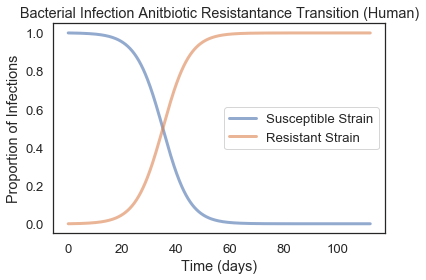

In [42]:
#Establish Systems
system = make_sys(89, 1, 0, 6, 0.2, 0, 112, 0.2, 1/3)

#Run Simulation
data = run_simulation(system.init, system, update_func)

#Graph
plot(data.index, data['susceptible'], label = 'Susceptible Strain')
plot(data.index, data['resistant'], label = 'Resistant Strain')

decorate(xlabel='Time (days)',
         ylabel='Proportion of Infections',
         title = 'Bacterial Infection Anitbiotic Resistantance Transition (Human)')

#### Population with Bacterial Resistance:
The proportion of the population in each population stock over the course of the epidemic.

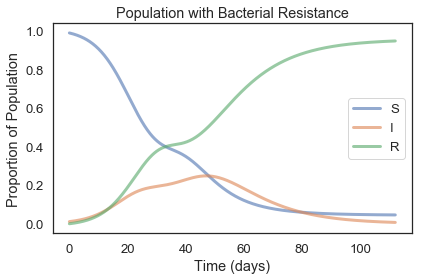

In [34]:
# Graph
plot(data.index, data['S'], label = 'S')
plot(data.index, data['I'], label = 'I')
plot(data.index, data['R'], label = 'R')
decorate(xlabel='Time (days)',
         ylabel='Proportion of Population',
         title = 'Population with Bacterial Resistance')

#### Basic SIR Model:
The proportion of the population in each population stock over the course of an epidemic where no bacterial resistance develops.

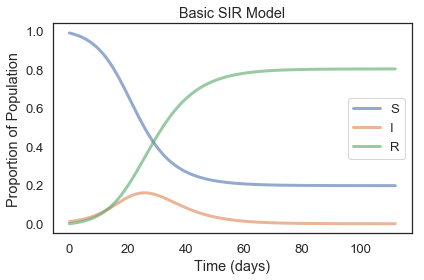

In [35]:
#Simulation rerun with comparison data
dato = run_simulation(system.init, system, update_func_basic)

#Graph
plot(dato.index, dato['S'], label = 'S')
plot(dato.index, dato['I'], label = 'I')
plot(dato.index, dato['R'], label = 'R')

decorate(xlabel='Time (days)',
         ylabel='Proportion of Population',
         title = 'Basic SIR Model')

#### Average Recovery Time:
The progression of the average number of contact days based on the proportion of the infected population that has contracted each strain of the bacterial infection. 1 prescription is 6 days long and treatment will end in 2 periods.

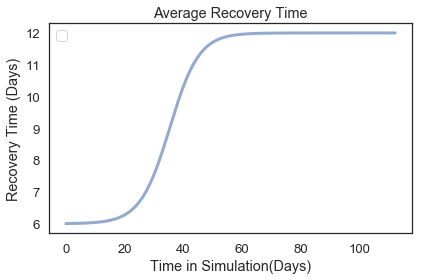

In [36]:
#Graph
plot(data.index, data['reco_time'])
decorate(xlabel='Time in Simulation(Days)',
         ylabel='Recovery Time (Days)',
         title = 'Average Recovery Time')


#### Total Infections:
The sum of the trapezoidal integrals of the data collected for the I stock. 

##### With Antibiotic Resistance:

In [37]:
#Trapiziodal integral
Iintegral = trapz(data['I'], data.index)

#Calcutations to apply data
infections = Iintegral * 90
percent = Iintegral * 100

#Output Results
print('In total there were ' + str(infections) + ' infections and thus ' + str(percent) + 
      '% of the population was infected in the simulation of bacterial antibiotic resistance. Each person will be infected ' +
      str(Iintegral) + ' times.')

In total there were 1139.9905765828248 infections and thus 1266.6561962031387% of the population was infected in the simulation of bacterial antibiotic resistance. Each person will be infected 12.666561962031388 times.


##### Basic SIR Model

In [38]:
#Trapiziodal integral
Iintegral = trapz(dato['I'], dato.index)

#Calcutations to apply data
infections = Iintegral * 90
percent = Iintegral * 100

#Output Results
print('In total there were ' + str(infections) + ' infections and thus ' + str(percent) + 
      '% of the population was infected in the simulation of a basic SIR model. Each person will be infected ' +
      str(Iintegral) + ' times.')

In total there were 433.17849290143675 infections and thus 481.3094365571519% of the population was infected in the simulation of a basic SIR model. Each person will be infected 4.813094365571519 times.


-----
## Interpretation:

There are several key differences between an epidemic with bacterial antibiotic resistance:

###### Time before equilibrium:
In the basic SIR model, it takes approximately 65 days for the infection to run its course. After this point, there are virtually no infected people and everyone has either recovered with immunity to the infection or never contracted the infection and there is no one else to infect them. With bacterial resistance, it takes about 112 days to reach this point. This is partly due to the fact that it takes the bacterial resistance curve about 65 day to stabilize and also because the population is not able to remain in the recovered stock in large proportions until the rate of mutation in the bacteria slows enough to severely limit the flow from the recovered to the susceptible stocks.

###### Total infections:
The total number of infections, or the number of times a healthy person came down with an illness, is much larger in the simulation with bacterial resistance. There were 433.18 infections in the basic model and 1139.99 infections in the bacterial resistance model for a difference of 706.81 infections. This is most certainly due to the population recycling. Logically, the data for the reference model should not exceed 100% however, since the simulation is not stopped as soon as the stocks have reached equilibrium the number of infections continues to build up because the simulation deals with proportions and not whole people. Therefore these results do not provide accurate data but an accurate scale for the epidemics. Based on this model, it is reasonable to conclude that bacterial antibiotic resistance increases the number of infections by 263.17%. This is further supported by the graphical representations of the model because the majority of the population end up in the recovered stock in the bacterial resistance simulation, while in the basic model, only about 80% of the population ends up in this category.

###### Peak of the Infection:
in the basic model, the peak number of infections is after about 25 days when around 15% of the population is infected. This timing and severity simply results from the faster infection rate than recovery rate which causes a build up in the infected stock to increase and in turn infect more people, pushing the infection rate higher. In contrast, when bacterial antibiotic resistance is involved, the peak of infections occurs much later, lasts longer, and is more severe. After about 50 days when around 25% of the population is infected the antibiotic-resistant infection has reached its max. This build-up likely occurs because the recovery time is approaching its maximum length of 12 days, slowing the flow out of the infected stock to a crawl while the flow in is rapidly increasing due to the drastic mutation of the bacteria that has occurred over the thirty previous days which is visibly supported by the steep slope of the resistant-strain bacteria in the Bacterial Infection Antibiotic Resistance Transition graph.

---
##### Room for improvement:
This model certainly follows the theme of probably inaccurate but possibly useful. The main fault lies in the poor treatment of the biological principles that apply to bacterial antibiotic resistance. In reality, bacteria likely does not follow a logistic trend when transitioning from resistant to non-resistant. Its mutation pattern is in fact largely based on how and when antibiotics are prescribed as well as if it occurs in the general population or a medical setting. It is also probable that all infections of a type of bacteria become antibiotics resistant. In most nation-wide data it only reached the point that 20% to 25% of infections were resistant-strain. The assumption was made that the small population and short time frame justified the choice to make this number reach 100%. In addition, developing antibiotic resistance is not the same thing as mutating to allow for reinfection. Antibiotic resistance is often a single or a few mutations that become prevalent while avoiding the immune system requires the constant mutation in a wide variety of aspects at the organism and population level. Overall, the main challenge with this model is that it seeks to simplify an incredibly complicated process of biology. Therefore, while it produces definitive results it is hard to justify or confirm these findings as there is no exact comparable data to what the model produces. Significant additions of stocks, flows, extraneous factors, and biological research could be added to make this model more accurate and useful, however, at that point it would be a different model altogether.

---
## Abstract:

How does a bacterial infection epidemic that develops antibiotic resistance compare to an epidemic of a non-mutating infection?

The key differences are that the epidemic with antibiotic resistance last longer, causes more infections, and delays, increases the severity, and prolongs the peak of the infection.

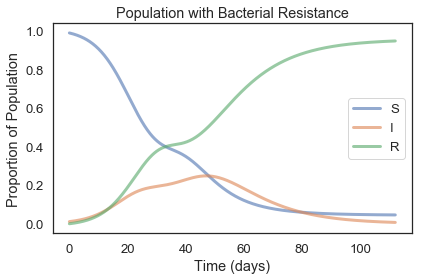

In [39]:
plot(data.index, data['S'], label = 'S')
plot(data.index, data['I'], label = 'I')
plot(data.index, data['R'], label = 'R')
decorate(xlabel='Time (days)',
         ylabel='Proportion of Population',
         title = 'Population with Bacterial Resistance')

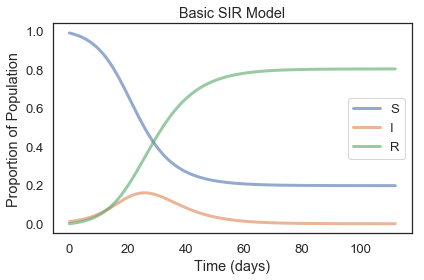

In [40]:
plot(dato.index, dato['S'], label = 'S')
plot(dato.index, dato['I'], label = 'I')
plot(dato.index, dato['R'], label = 'R')

decorate(xlabel='Time (days)',
         ylabel='Proportion of Population',
         title = 'Basic SIR Model')

This model provides clear identifications and explanations of the differences between the two types of infections. It struggles to fully capture the core biological principles that goven antibiotic resistance which sacrifices some of its accuracy for simplicity.